In [2]:
import os

# ---- Prevent PyTorch/libomp CPU segfaults on macOS ----
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Optional: reduce HF logging noise
os.environ["TRANSFORMERS_VERBOSITY"] = "error"


In [3]:
import re
import json
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

from xgboost import XGBClassifier

import torch
from sentence_transformers import SentenceTransformer


In [4]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Hard cap Torch threading
torch.set_num_threads(1)
torch.set_num_interop_threads(1)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [5]:
df = pd.read_csv("../data/eda_papers.csv")
print(f"Loaded {len(df)} papers.")
df.head()


Loaded 102215 papers.


,arxiv_id,title,abstract,authors,primary_category,all_categories,published_at,citation_count
0,2511.01118,Generative Machine Learning Models for the Dec...,Charge carrier dynamics critically affect the ...,Li Raymond|Salim Flora|Wang Sijin|Wright Brendan,cond-mat.mtrl-sci,cond-mat.mtrl-sci|cs.LG,2025-11-02T23:32:05+00:00,0
1,2511.01113,S2Doc -- Spatial-Semantic Document Format,Documents are a common way to store and share ...,Sebastian Kempf|Frank Puppe,cs.DL,cs.DL|cs.CL,2025-11-02T23:06:03+00:00,0
2,2511.01109,Anatomically Constrained Transformers for Echo...,Video transformers have recently demonstrated ...,Alexander Thorley|Agis Chartsias|Jordan Strom|...,cs.CV,cs.CV,2025-11-02T22:52:30+00:00,0
3,2511.01107,SLAP: Shortcut Learning for Abstract Planning,Long-horizon decision-making with sparse rewar...,Y. Isabel Liu|Bowen Li|Benjamin Eysenbach|Tom ...,cs.RO,cs.RO|cs.LG,2025-11-02T22:48:31+00:00,1
4,2511.01104,HarnessLLM: Automatic Testing Harness Generati...,Existing LLM-based automatic test generation m...,Yujian Liu|Jiabao Ji|Yang Zhang|Wenbo Guo|Tomm...,cs.SE,cs.SE|cs.CL,2025-11-02T22:41:15+00:00,0


In [6]:
df['published_at'] = pd.to_datetime(df['published_at'])
df['age_days'] = (pd.Timestamp.now(tz='UTC') - df['published_at']).dt.days

# Text features
df['title_len'] = df['title'].apply(len)
df['abstract_len'] = df['abstract'].apply(len)

# Author count (splitting by pipe)
df['num_authors'] = df['authors'].apply(lambda x: len(str(x).split('|')) if pd.notna(x) else 0)

# Filter out very new papers if needed (though API query handled this)
df = df[df['age_days'] > 30]

df[['title_len', 'abstract_len', 'num_authors', 'age_days', 'citation_count']].describe()

,title_len,abstract_len,num_authors,age_days,citation_count
count,101554.000000,101554.000000,101554.000000,101554.000000,101554.000000
mean,82.848593,1320.153682,5.412628,202.935049,2.631575
std,23.154973,308.033216,12.580414,97.265659,19.014190
min,5.000000,51.000000,1.000000,31.000000,0.000000
25%,68.000000,1110.000000,3.000000,121.000000,0.000000
50%,82.000000,1320.000000,5.000000,202.000000,0.000000
75%,97.000000,1538.000000,6.000000,280.000000,2.000000
max,240.000000,3488.000000,3435.000000,373.000000,3176.000000


In [7]:
df['age_bin'] = (df['age_days'] // 7) * 7

In [8]:
df["age_bin"] = pd.to_numeric(df["age_bin"], errors="coerce")
df["citation_count"] = pd.to_numeric(df["citation_count"], errors="coerce").fillna(0)
df = df.dropna(subset=["age_bin"]).copy()
df["age_bin"] = df["age_bin"].astype(int)


In [9]:
degree = 1.08
c1 = 0.019   # mid
c2 = 0.035   # high

mid_threshold = c1 * (df["age_bin"] ** degree)
high_threshold = c2 * (df["age_bin"] ** degree)

conditions = [
    df["citation_count"] < mid_threshold,
    (df["citation_count"] >= mid_threshold) & (df["citation_count"] < high_threshold),
    df["citation_count"] >= high_threshold
]
choices = ["low", "mid", "high"]

df["popularity_bucket"] = np.select(conditions, choices, default="low")
df["popularity_bucket"].value_counts()


popularity_bucket
low     93536
mid      4438
high     3580
Name: count, dtype: int64

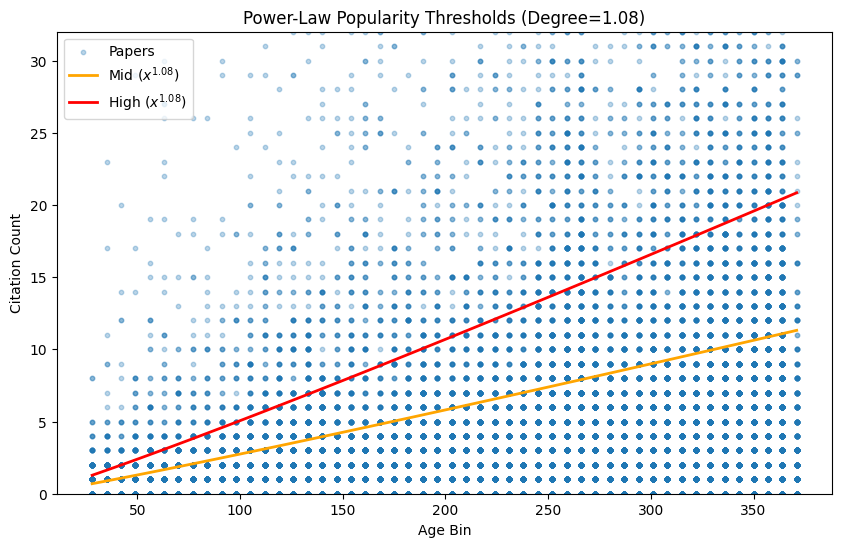

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(df["age_bin"], df["citation_count"], alpha=0.3, label="Papers", s=10)

x_range = np.linspace(df["age_bin"].min(), df["age_bin"].max(), 100)
plt.plot(x_range, c1 * (x_range ** degree), color="orange", linewidth=2, label=f"Mid ($x^{{{degree}}}$)")
plt.plot(x_range, c2 * (x_range ** degree), color="red", linewidth=2, label=f"High ($x^{{{degree}}}$)")

plt.title(f"Power-Law Popularity Thresholds (Degree={degree})")
plt.xlabel("Age Bin")
plt.ylabel("Citation Count")
plt.ylim(0, df["citation_count"].quantile(0.99))
plt.legend()
plt.show()


In [11]:
pivot_df = (
    df.groupby(["age_bin", "popularity_bucket"])
      .size()
      .unstack(fill_value=0)
)
pivot_pct = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100
pivot_pct = pivot_pct[["low", "mid", "high"]]
pivot_pct.head()


popularity_bucket,low,mid,high
age_bin,,,
28,87.576687,8.588957,3.834356
35,87.720181,8.706593,3.573226
42,95.326350,0.000000,4.673650
49,94.258016,2.311708,3.430276
56,93.608247,2.835052,3.556701


In [12]:
_WORD_RE = re.compile(r"[A-Za-z0-9]+(?:'[A-Za-z0-9]+)?")
_SENT_SPLIT_RE = re.compile(r"[.!?]+\s+")
_URL_RE = re.compile(r"https?://\S+|www\.\S+")
_EMAIL_RE = re.compile(r"\b[\w\.-]+@[\w\.-]+\.\w+\b")

def add_offline_paper_features(
    df: pd.DataFrame,
    *,
    title_col: str = "title",
    abstract_col: str = "abstract",
    authors_col: str = "authors",
    primary_cat_col: str = "primary_category",
    all_cats_col: str = "all_categories",
    published_at_col: str = "published_at",
    author_sep: str = "|",
) -> pd.DataFrame:
    """
    Add offline-only features for impact prediction.
    No internet calls; relies only on existing metadata/text.

    Returns a copy of df with additional feature columns.
    """
    out = df.copy()

    # ---------- Helpers ----------
    def safe_str(s) -> str:
        return "" if pd.isna(s) else str(s)

    def words(s: str):
        return _WORD_RE.findall(s)

    def sentence_count(s: str) -> int:
        s = s.strip()
        if not s:
            return 0
        # Rough: split on punctuation boundaries
        return max(1, len(_SENT_SPLIT_RE.split(s)))

    def keyword_flags(text_lower: str, patterns: dict) -> dict:
        return {name: int(bool(re.search(pat, text_lower))) for name, pat in patterns.items()}

    # ---------- Parse datetime ----------
    if published_at_col in out.columns:
        dt = pd.to_datetime(out[published_at_col], errors="coerce", utc=True)
        out["pub_hour_utc"] = dt.dt.hour
        out["pub_dow"] = dt.dt.dayofweek          # 0=Mon
        out["pub_month"] = dt.dt.month
        out["is_weekend"] = dt.dt.dayofweek.isin([5, 6]).astype("Int64")

    # ---------- Category features ----------
    if all_cats_col in out.columns:
        cats = out[all_cats_col].fillna("").astype(str)
        out["num_categories"] = cats.apply(lambda x: 0 if x.strip() == "" else len([c for c in x.split("|") if c.strip()]))
        out["is_cross_listed"] = (out["num_categories"] > 1).astype("Int64")

        # Simple category family flags
        def starts_with(prefix: str):
            return cats.apply(lambda x: int(any(c.strip().startswith(prefix) for c in x.split("|") if c.strip())))
        out["has_cs"] = starts_with("cs.")
        out["has_stat"] = starts_with("stat.")
        out["has_math"] = starts_with("math.")
        out["has_eess"] = starts_with("eess.")
        out["has_qbio"] = starts_with("q-bio.")

    if primary_cat_col in out.columns:
        pc = out[primary_cat_col].fillna("").astype(str)
        out["primary_is_cs"] = pc.str.startswith("cs.").astype("Int64")
        out["primary_is_stat"] = pc.str.startswith("stat.").astype("Int64")

    # ---------- Author features ----------
    if authors_col in out.columns:
        auth = out[authors_col].fillna("").astype(str)

        # Split authors
        author_lists = auth.apply(lambda x: [a.strip() for a in x.split(author_sep) if a.strip()])
        out["num_authors_offline"] = author_lists.apply(len)

        out["first_author"] = author_lists.apply(lambda xs: xs[0] if len(xs) else "")
        out["last_author"] = author_lists.apply(lambda xs: xs[-1] if len(xs) else "")

        # Name-length stats (proxy for non-western tokenization / formatting differences)
        author_name_lens = author_lists.apply(lambda xs: [len(a) for a in xs] if xs else [])
        out["author_name_len_mean"] = author_name_lens.apply(lambda ls: float(np.mean(ls)) if ls else np.nan)
        out["author_name_len_max"] = author_name_lens.apply(lambda ls: float(np.max(ls)) if ls else np.nan)

        # Simple signals
        out["has_many_authors_ge5"] = (out["num_authors_offline"] >= 5).astype("Int64")
        out["has_many_authors_ge10"] = (out["num_authors_offline"] >= 10).astype("Int64")

    # ---------- Text features ----------
    title = out.get(title_col, "").apply(safe_str)
    abstract = out.get(abstract_col, "").apply(safe_str)

    title_lower = title.str.lower()
    abs_lower = abstract.str.lower()

    # Basic lengths
    out["title_char_len"] = title.str.len()
    out["abstract_char_len"] = abstract.str.len()

    out["title_word_count"] = title.apply(lambda s: len(words(s)))
    out["abstract_word_count"] = abstract.apply(lambda s: len(words(s)))

    # Avg word length
    out["title_avg_word_len"] = title.apply(lambda s: np.mean([len(w) for w in words(s)]) if words(s) else np.nan)
    out["abstract_avg_word_len"] = abstract.apply(lambda s: np.mean([len(w) for w in words(s)]) if words(s) else np.nan)

    # Sentence counts + avg sentence length (words)
    out["abstract_sentence_count"] = abstract.apply(sentence_count)
    out["abstract_avg_words_per_sentence"] = (
        out["abstract_word_count"] / out["abstract_sentence_count"].replace(0, np.nan)
    )

    # Punctuation / digit ratios
    def ratio_of(pattern: str, s: str) -> float:
        if not s:
            return 0.0
        return len(re.findall(pattern, s)) / max(1, len(s))

    out["title_digit_ratio"] = title.apply(lambda s: ratio_of(r"\d", s))
    out["abstract_digit_ratio"] = abstract.apply(lambda s: ratio_of(r"\d", s))
    out["title_punct_ratio"] = title.apply(lambda s: ratio_of(r"[^\w\s]", s))
    out["abstract_punct_ratio"] = abstract.apply(lambda s: ratio_of(r"[^\w\s]", s))

    # URL/email presence
    out["abstract_has_url"] = abstract.apply(lambda s: int(bool(_URL_RE.search(s)))).astype("Int64")
    out["abstract_has_email"] = abstract.apply(lambda s: int(bool(_EMAIL_RE.search(s)))).astype("Int64")

    # Specific link/identifier flags
    out["mentions_github"] = abs_lower.str.contains("github.com", regex=False).astype("Int64")
    out["mentions_code"] = abs_lower.str.contains("code", regex=False).astype("Int64")
    out["mentions_dataset"] = abs_lower.str.contains("dataset", regex=False).astype("Int64")
    out["mentions_benchmark"] = abs_lower.str.contains("benchmark", regex=False).astype("Int64")
    out["mentions_arxiv_id"] = abs_lower.str.contains("arxiv", regex=False).astype("Int64")
    out["mentions_doi"] = abs_lower.str.contains("doi", regex=False).astype("Int64")

    # Keyword patterns (title+abstract)
    kw_patterns = {
        # format / type
        "is_survey": r"\bsurvey\b|\breview\b",
        "is_benchmark_paper": r"\bbenchmark\b|\bleaderboard\b",
        "is_dataset_paper": r"\bdataset\b|\bcorpus\b",
        "is_system_paper": r"\bsystem\b|\bframework\b|\bplatform\b",
        "has_theory": r"\btheorem\b|\bproof\b|\bconvergence\b",

        # hot topics
        "mentions_llm": r"\bllm\b|large language model|language model",
        "mentions_diffusion": r"\bdiffusion\b",
        "mentions_transformer": r"\btransformer\b",
        "mentions_agent": r"\bagent\b|\btool\b|\bplanning\b",
        "mentions_rl": r"\breinforcement learning\b|\brl\b",
        "mentions_multimodal": r"\bmultimodal\b|vision-language|vlm",

        # “impact-ish” phrasing
        "claims_sota": r"\bsota\b|state[- ]of[- ]the[- ]art",
        "claims_novel": r"\bnovel\b|\bnew\b|\bfirst\b|\bintroduce\b",
        "mentions_open_source": r"open[- ]source|we release|code is available",
        "mentions_experiments": r"\bexperiments?\b|\bwe evaluate\b|\bresults?\b",
    }

    # Apply to concatenated text
    combined_lower = (title_lower + " " + abs_lower).fillna("")
    kw_df = pd.DataFrame(
        combined_lower.apply(lambda s: keyword_flags(s, kw_patterns)).tolist(),
        index=out.index,
    )
    out = pd.concat([out, kw_df], axis=1)

    # Lexical diversity proxy (type-token ratio) on abstract
    def ttr(s: str) -> float:
        ws = [w.lower() for w in words(s)]
        if not ws:
            return np.nan
        return len(set(ws)) / len(ws)

    out["abstract_ttr"] = abstract.apply(ttr)

    # Optional: log transforms for stability (often helps tree models)
    out["log_abstract_word_count"] = np.log1p(out["abstract_word_count"])
    out["log_num_authors"] = np.log1p(out.get("num_authors_offline", 0))

    return out


In [13]:
feat_df = add_offline_paper_features(df)
print("feat_df shape:", feat_df.shape)


feat_df shape: (101554, 72)


In [14]:
feat_df["age_days"] = pd.to_numeric(feat_df.get("age_days", np.nan), errors="coerce")
model_df = feat_df[feat_df["age_days"] >= 200].copy()
print("model_df:", model_df.shape)

# Target
ordered_classes = ["low", "mid", "high"]
y = pd.Categorical(model_df["popularity_bucket"].astype(str), categories=ordered_classes, ordered=True).codes
if (y == -1).any():
    raise ValueError("Found unexpected popularity_bucket values outside low/mid/high.")


model_df: (51454, 72)


In [15]:
leak_cols = {"citation_count", "age_days", "age_bin", "popularity_bucket"}
id_cols = {"arxiv_id"}  # optional
drop_cols = leak_cols | id_cols

X = model_df.drop(columns=[c for c in drop_cols if c in model_df.columns]).copy()
print("X shape:", X.shape)


X shape: (51454, 67)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)


In [24]:
X_train.columns

Index(['title', 'abstract', 'authors', 'primary_category', 'all_categories',
       'published_at', 'title_len', 'abstract_len', 'num_authors',
       'pub_hour_utc', 'pub_dow', 'pub_month', 'is_weekend', 'num_categories',
       'is_cross_listed', 'has_cs', 'has_stat', 'has_math', 'has_eess',
       'has_qbio', 'primary_is_cs', 'primary_is_stat', 'num_authors_offline',
       'first_author', 'last_author', 'author_name_len_mean',
       'author_name_len_max', 'has_many_authors_ge5', 'has_many_authors_ge10',
       'title_char_len', 'abstract_char_len', 'title_word_count',
       'abstract_word_count', 'title_avg_word_len', 'abstract_avg_word_len',
       'abstract_sentence_count', 'abstract_avg_words_per_sentence',
       'title_digit_ratio', 'abstract_digit_ratio', 'title_punct_ratio',
       'abstract_punct_ratio', 'abstract_has_url', 'abstract_has_email',
       'mentions_github', 'mentions_code', 'mentions_dataset',
       'mentions_benchmark', 'mentions_arxiv_id', 'mentions_doi',

In [17]:
TITLE_COL = "title"
ABSTRACT_COL = "abstract"

cat_cols = ["primary_category"] if "primary_category" in X_train.columns else []

num_cols = X_train.select_dtypes(include=["int64","int32","float64","float32","bool"]).columns.tolist()
num_cols = [c for c in num_cols if c not in {TITLE_COL, ABSTRACT_COL}]


In [19]:
num_imputer = SimpleImputer(strategy="median")
X_train_num = num_imputer.fit_transform(X_train[num_cols]) if num_cols else np.zeros((len(X_train), 0), np.float32)
X_test_num  = num_imputer.transform(X_test[num_cols]) if num_cols else np.zeros((len(X_test), 0), np.float32)

if cat_cols:
    cat_imputer = SimpleImputer(strategy="most_frequent")
    X_train_cat_raw = cat_imputer.fit_transform(X_train[cat_cols])
    X_test_cat_raw  = cat_imputer.transform(X_test[cat_cols])

    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_train_cat = ohe.fit_transform(X_train_cat_raw).astype(np.float32)
    X_test_cat  = ohe.transform(X_test_cat_raw).astype(np.float32)
else:
    X_train_cat = np.zeros((len(X_train), 0), np.float32)
    X_test_cat  = np.zeros((len(X_test), 0), np.float32)


In [28]:
EMB_MODEL = "sentence-transformers/all-MiniLM-L6-v2"
CACHE_DIR = "./emb_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

MAX_CHARS = 6000          # prevents pathological tokenization
CHUNK_SIZE = 2000         # adjust smaller if still unstable
BATCH_SIZE = 16           # keep small on macOS
DEVICE = "cpu"            # use CPU for stability

def build_text(df_):
    t = df_.get(TITLE_COL, "").fillna("").astype(str)
    a = df_.get(ABSTRACT_COL, "").fillna("").astype(str)
    return (t + " [SEP] " + a).str.slice(0, MAX_CHARS)

def encode_resumable(texts: pd.Series, out_prefix: str, model_name: str):
    """
    Writes embeddings to:
      {out_prefix}.mmap  (float32 memmap)
      {out_prefix}.json  (progress)
    Resume supported.
    """
    texts = texts.fillna("").astype(str)
    n = len(texts)

    prog_path = out_prefix + ".json"
    mmap_path = out_prefix + ".mmap"

    st = SentenceTransformer(model_name, device=DEVICE)

    # Determine embedding dim with a tiny probe
    probe = st.encode(texts.iloc[:4].tolist(), batch_size=4, convert_to_numpy=True, normalize_embeddings=True)
    dim = probe.shape[1]

    # Load or init progress
    if os.path.exists(prog_path) and os.path.exists(mmap_path):
        with open(prog_path, "r") as f:
            prog = json.load(f)
        start_idx = int(prog.get("done_until", 0))
        if prog.get("n") != n or prog.get("dim") != dim:
            print("Progress file mismatch; restarting embeddings from scratch.")
            start_idx = 0
            os.remove(prog_path)
            os.remove(mmap_path)
    else:
        start_idx = 0

    # Create/open memmap
    emb_mm = np.memmap(mmap_path, dtype="float32", mode="w+" if start_idx == 0 else "r+", shape=(n, dim))

    # Write probe if starting fresh
    if start_idx == 0:
        emb_mm[:probe.shape[0], :] = probe.astype(np.float32)
        start_idx = probe.shape[0]
        emb_mm.flush()
        with open(prog_path, "w") as f:
            json.dump({"n": n, "dim": dim, "done_until": start_idx}, f)

    # Encode remaining in chunks
    for s in range(start_idx, n, CHUNK_SIZE):
        e = min(s + CHUNK_SIZE, n)
        print(f"Encoding {s}:{e} / {n} ...")

        chunk = texts.iloc[s:e].tolist()
        emb = st.encode(
            chunk,
            batch_size=BATCH_SIZE,
            show_progress_bar=True,
            convert_to_numpy=True,
            normalize_embeddings=True,
        ).astype(np.float32)

        emb_mm[s:e, :] = emb
        emb_mm.flush()

        with open(prog_path, "w") as f:
            json.dump({"n": n, "dim": dim, "done_until": e}, f)

    # Return as a normal ndarray view (copies from memmap on demand)
    return np.array(emb_mm)

# Build text
train_texts = build_text(X_train)
test_texts  = build_text(X_test)

# Encode (resumable)
X_train_emb = encode_resumable(train_texts, os.path.join(CACHE_DIR, "train_emb"), EMB_MODEL)
X_test_emb  = encode_resumable(test_texts,  os.path.join(CACHE_DIR, "test_emb"),  EMB_MODEL)

print("X_train_emb:", X_train_emb.shape)
print("X_test_emb :", X_test_emb.shape)


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

Progress file mismatch; restarting embeddings from scratch.
Encoding 4:2004 / 40922 ...


Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Encoding 2004:4004 / 40922 ...


Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Encoding 4004:6004 / 40922 ...


Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Encoding 6004:8004 / 40922 ...


Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Encoding 8004:10004 / 40922 ...


Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Encoding 10004:12004 / 40922 ...


Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Encoding 12004:14004 / 40922 ...


Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Encoding 14004:16004 / 40922 ...


Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Encoding 16004:18004 / 40922 ...


Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Encoding 18004:20004 / 40922 ...


Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Encoding 20004:22004 / 40922 ...


Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Encoding 22004:24004 / 40922 ...


Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Encoding 24004:26004 / 40922 ...


Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Encoding 26004:28004 / 40922 ...


Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Encoding 28004:30004 / 40922 ...


Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Encoding 30004:32004 / 40922 ...


Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Encoding 32004:34004 / 40922 ...


Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Encoding 34004:36004 / 40922 ...


Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Encoding 36004:38004 / 40922 ...


Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Encoding 38004:40004 / 40922 ...


Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Encoding 40004:40922 / 40922 ...


Batches:   0%|          | 0/58 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

Progress file mismatch; restarting embeddings from scratch.
Encoding 4:2004 / 10231 ...


Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Encoding 2004:4004 / 10231 ...


Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Encoding 4004:6004 / 10231 ...


Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Encoding 6004:8004 / 10231 ...


Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Encoding 8004:10004 / 10231 ...


Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Encoding 10004:10231 / 10231 ...


Batches:   0%|          | 0/15 [00:00<?, ?it/s]

X_train_emb: (40922, 384)
X_test_emb : (10231, 384)


In [ ]:
X_train_final = np.hstack([X_train_emb, X_train_num.astype(np.float32), X_train_cat])
X_test_final  = np.hstack([X_test_emb,  X_test_num.astype(np.float32),  X_test_cat])

print("Final shapes:", X_train_final.shape, X_test_final.shape)


NameError: name 'X_train_emb' is not defined

In [ ]:
classes = np.array([0,1,2])
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
cw_dict = dict(zip(classes, cw))
sample_w = np.array([cw_dict[int(i)] for i in y_train], dtype=np.float32)

xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    n_estimators=900,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.7,
    min_child_weight=3,
    gamma=1,
    reg_lambda=2.0,
    random_state=SEED,
    n_jobs=-1,
)

xgb.fit(X_train_final, y_train, sample_weight=sample_w)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'multi:softprob'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.7
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes fr

In [27]:
sample_w

array([0.37025625, 0.37025625, 6.1086397 , ..., 0.37025625, 0.37025625,
       0.37025625], shape=(40372,), dtype=float32)

In [25]:
y_pred = xgb.predict(X_test_final)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1:", f1_score(y_test, y_pred, average="macro"))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, labels=[0,1,2], target_names=ordered_classes))

cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{c}" for c in ordered_classes],
    columns=[f"pred_{c}" for c in ordered_classes],
)
print("\nConfusion matrix:\n")
print(cm_df)


Accuracy: 0.8989498712106202
Macro F1: 0.47153300034280576

Classification report:

              precision    recall  f1-score   support

         low       0.92      0.98      0.95      9087
         mid       0.18      0.04      0.07       551
        high       0.46      0.35      0.40       456

    accuracy                           0.90     10094
   macro avg       0.52      0.46      0.47     10094
weighted avg       0.86      0.90      0.88     10094


Confusion matrix:

           pred_low  pred_mid  pred_high
true_low       8892        74        121
true_mid        464        22         65
true_high       267        29        160


In [26]:
pd.Series(y_train).value_counts(normalize=True)


0    0.900277
1    0.054568
2    0.045155
Name: proportion, dtype: float64

## Save Data

In [68]:
import os
import pandas as pd

os.makedirs("./splits", exist_ok=True)

# X
X_train_df = pd.DataFrame(
    X_train_final,
    columns=[str(i) for i in range(X_train_final.shape[1])]
)

X_test_df = pd.DataFrame(
    X_test_final,
    columns=[str(i) for i in range(X_test_final.shape[1])]
)

# y (numpy → DataFrame)
y_train_df = pd.DataFrame(y_train, columns=["label"])
y_test_df  = pd.DataFrame(y_test,  columns=["label"])

# text (if numpy)
train_texts_df = pd.DataFrame(train_texts, columns=["text"])
test_texts_df  = pd.DataFrame(test_texts,  columns=["text"])

# Save everything with same engine for consistency
X_train_df.to_parquet("./splits/X_train_final.parquet", engine="fastparquet", index=False)
X_test_df.to_parquet("./splits/X_test_final.parquet",  engine="fastparquet", index=False)

y_train_df.to_parquet("./splits/y_train.parquet", engine="fastparquet", index=False)
y_test_df.to_parquet("./splits/y_test.parquet",  engine="fastparquet", index=False)

train_texts_df.to_parquet("./splits/train_texts.parquet", engine="fastparquet", index=False)
test_texts_df.to_parquet("./splits/test_texts.parquet",  engine="fastparquet", index=False)

print("✅ Split saved.")


✅ Split saved.


### Without Embedding

In [21]:
X_train_wo_emb = np.hstack([X_train_num.astype(np.float32), X_train_cat])
X_test_wo_emb  = np.hstack([X_test_num.astype(np.float32),  X_test_cat])

print("Final shapes:", X_train_wo_emb.shape, X_test_wo_emb.shape)


Final shapes: (41163, 185) (10291, 185)


In [71]:
import os
import pandas as pd

os.makedirs("./splits", exist_ok=True)

# X
X_train_wo_emb_df = pd.DataFrame(
    X_train_wo_emb,
    columns=[str(i) for i in range(X_train_wo_emb.shape[1])]
)

X_test_wo_emb_df = pd.DataFrame(
    X_test_wo_emb,
    columns=[str(i) for i in range(X_test_wo_emb.shape[1])]
)

# y (numpy → DataFrame)
# y_train_df = pd.DataFrame(y_train, columns=["label"])
# y_test_df  = pd.DataFrame(y_test,  columns=["label"])

# text (if numpy)
# train_texts_df = pd.DataFrame(train_texts, columns=["text"])
# test_texts_df  = pd.DataFrame(test_texts,  columns=["text"])

# Save everything with same engine for consistency
X_train_wo_emb_df.to_parquet("./splits/X_train_wo_emb.parquet", engine="fastparquet", index=False)
X_test_wo_emb_df.to_parquet("./splits/X_test_wo_emb.parquet",  engine="fastparquet", index=False)

# y_train_df.to_parquet("./splits/y_train.parquet", engine="fastparquet", index=False)
# y_test_df.to_parquet("./splits/y_test.parquet",  engine="fastparquet", index=False)

# train_texts_df.to_parquet("./splits/train_texts.parquet", engine="fastparquet", index=False)
# test_texts_df.to_parquet("./splits/test_texts.parquet",  engine="fastparquet", index=False)

print("✅ Split without embedding saved.")


✅ Split without embedding saved.


## Use Small Model

In [29]:
import os
import json
import hashlib
import pandas as pd
from typing import Dict, Any, List
from tenacity import retry, wait_exponential, stop_after_attempt
from dotenv import load_dotenv

In [ ]:
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
if not OPENAI_API_KEY:
    raise ValueError("Missing OPENAI_API_KEY. Put it in .env or export it.")

from openai import OpenAI
client = OpenAI(api_key=OPENAI_API_KEY)

MODEL_NAME = "gpt-4o-mini"

SCORE_JSON_SCHEMA = {
    "name": "paper_score",
    "schema": {
        "type": "object",
        "additionalProperties": False,
        "properties": {
            "impact": {"type": "integer", "minimum": 0, "maximum": 5},
            "novelty": {"type": "integer", "minimum": 0, "maximum": 5},
            "technical_depth": {"type": "integer", "minimum": 0, "maximum": 5},
            "clarity": {"type": "integer", "minimum": 0, "maximum": 5},
            "adoption_likelihood": {"type": "integer", "minimum": 0, "maximum": 5},
        },
        "required": ["impact", "novelty", "technical_depth", "clarity", "adoption_likelihood"],
    },
}

def _stable_hash(s: str) -> str:
    return hashlib.sha256(s.encode("utf-8")).hexdigest()

@retry(wait=wait_exponential(min=1, max=30), stop=stop_after_attempt(6))
def score_one_text(text: str) -> Dict[str, Any]:
    prompt = (
        "You are reviewing an arXiv-style paper based ONLY on title+abstract text.\n"
        "Do NOT use citations or external knowledge.\n"
        "Score each dimension as an integer from 0 to 5 (0=very low, 5=very high).\n"
        "Return JSON that matches the schema.\n\n"
        f"Text:\n{text}"
    )

    resp = client.responses.create(
        model=MODEL_NAME,
        input=prompt,
        temperature=0,
        text={
            "format": {
                "type": "json_schema",
                "name": SCORE_JSON_SCHEMA["name"],
                "strict": True,
                "schema": SCORE_JSON_SCHEMA["schema"],
            }
        },
    )

    data = json.loads(resp.output_text)

    # Coerce + clamp
    out = {k: max(0, min(5, int(data[k]))) for k in SCORE_JSON_SCHEMA["schema"]["required"]}
    return out

def score_texts_with_cache(
    texts: pd.Series,
    cache_path: str,
    max_items: int | None = None,
    print_every: int = 25,
) -> pd.DataFrame:
    """
    Scores a Series of texts. Uses a JSONL cache keyed by hash(text).
    Returns a DataFrame aligned to texts.index with 5 score columns (int).
    """
    os.makedirs(os.path.dirname(cache_path), exist_ok=True)

    # Load cache
    cache: Dict[str, Dict[str, Any]] = {}
    if os.path.exists(cache_path):
        with open(cache_path, "r", encoding="utf-8") as f:
            for line in f:
                rec = json.loads(line)
                cache[rec["key"]] = rec["value"]

    results = []
    n = len(texts)

    for i, (idx, text) in enumerate(texts.items(), start=1):
        if max_items is not None and i > max_items:
            break

        t = "" if pd.isna(text) else str(text)
        key = _stable_hash(t)

        if key in cache:
            val = cache[key]
        else:
            val = score_one_text(t)
            cache[key] = val
            with open(cache_path, "a", encoding="utf-8") as f:
                f.write(json.dumps({"key": key, "value": val}, ensure_ascii=False) + "\n")

        results.append((idx, val))

        if i % print_every == 0 or i == n:
            print(f"Scored {i}/{n}")

    out_df = pd.DataFrame([v for _, v in results], index=[idx for idx, _ in results])
    return out_df.reindex(texts.index)


In [ ]:
LLM_CACHE_DIR = "./llm_score_cache"
os.makedirs(LLM_CACHE_DIR, exist_ok=True)

# Strongly recommend a pilot first to validate signal + cost
train_scores = score_texts_with_cache(
    train_texts,
    cache_path=os.path.join(LLM_CACHE_DIR, "train_scores.jsonl"),
    # max_items=300
)

test_scores = score_texts_with_cache(
    test_texts,
    cache_path=os.path.join(LLM_CACHE_DIR, "test_scores.jsonl"),
    # max_items=200
)

print(train_scores.head())


Scored 25/40372
Scored 50/40372
Scored 75/40372
Scored 100/40372
Scored 125/40372
Scored 150/40372
Scored 175/40372
Scored 200/40372
Scored 225/40372
Scored 250/40372
Scored 275/40372
Scored 300/40372
Scored 25/10094
Scored 50/10094
Scored 75/10094
Scored 100/10094
Scored 125/10094
Scored 150/10094
Scored 175/10094
Scored 200/10094
       impact  novelty  technical_depth  clarity  adoption_likelihood
70961     4.0      5.0              4.0      4.0                  3.0
60630     5.0      4.0              5.0      4.0                  5.0
71757     4.0      5.0              4.0      4.0                  3.0
75593     4.0      4.0              5.0      4.0                  4.0
77241     4.0      5.0              5.0      4.0                  4.0


In [61]:
train_scores[301:]

,impact,novelty,technical_depth,clarity,adoption_likelihood
63875,NaN,NaN,NaN,NaN,NaN
71454,NaN,NaN,NaN,NaN,NaN
46094,NaN,NaN,NaN,NaN,NaN
40149,NaN,NaN,NaN,NaN,NaN
55144,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
43798,NaN,NaN,NaN,NaN,NaN
63430,NaN,NaN,NaN,NaN,NaN
73876,NaN,NaN,NaN,NaN,NaN
73029,NaN,NaN,NaN,NaN,NaN


In [43]:
X_train_llm = train_scores.to_numpy(dtype=np.float32)
X_test_llm  = test_scores.to_numpy(dtype=np.float32)

X_train_final = np.hstack([X_train_emb, X_train_num.astype(np.float32), X_train_cat, X_train_llm])
X_test_final  = np.hstack([X_test_emb,  X_test_num.astype(np.float32),  X_test_cat,  X_test_llm])

print("Final shapes w/ LLM:", X_train_final.shape, X_test_final.shape)


Final shapes w/ LLM: (40372, 574) (10094, 574)


In [44]:
classes = np.array([0,1,2])
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
cw_dict = dict(zip(classes, cw))
sample_w = np.array([cw_dict[int(i)] for i in y_train], dtype=np.float32)

xgb_ai = XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    n_estimators=900,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.7,
    min_child_weight=3,
    gamma=1,
    reg_lambda=2.0,
    random_state=SEED,
    n_jobs=-1,
)

xgb_ai.fit(X_train_final, y_train, sample_weight=sample_w)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'multi:softprob'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.7
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes fr

In [45]:
y_pred = xgb_ai.predict(X_test_final)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1:", f1_score(y_test, y_pred, average="macro"))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, labels=[0,1,2], target_names=ordered_classes))

cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{c}" for c in ordered_classes],
    columns=[f"pred_{c}" for c in ordered_classes],
)
print("\nConfusion matrix:\n")
print(cm_df)


Accuracy: 0.8996433524866257
Macro F1: 0.47504639151697975

Classification report:

              precision    recall  f1-score   support

         low       0.92      0.98      0.95      9087
         mid       0.21      0.04      0.07       551
        high       0.45      0.37      0.40       456

    accuracy                           0.90     10094
   macro avg       0.53      0.46      0.48     10094
weighted avg       0.86      0.90      0.88     10094


Confusion matrix:

           pred_low  pred_mid  pred_high
true_low       8891        59        137
true_mid        463        23         65
true_high       259        30        167


## Other LLM Category

In [67]:
import json
import re

_JSON_FENCE_RE = re.compile(r"```(?:json)?\s*(\{.*?\})\s*```", re.DOTALL)
_JSON_OBJ_RE = re.compile(r"(\{.*\})", re.DOTALL)

def parse_json_strictish(s: str) -> dict:
    """
    Try multiple strategies to parse JSON from a model response.
    Handles:
    - pure JSON
    - ```json ... ```
    - extra text before/after JSON
    """
    s = (s or "").strip()

    # 1) Pure JSON
    try:
        return json.loads(s)
    except Exception:
        pass

    # 2) JSON inside fenced block
    m = _JSON_FENCE_RE.search(s)
    if m:
        return json.loads(m.group(1))

    # 3) First {...} blob
    m = _JSON_OBJ_RE.search(s)
    if m:
        return json.loads(m.group(1))

    raise json.JSONDecodeError("Could not find valid JSON object", s, 0)


In [68]:
from tenacity import retry, wait_exponential, stop_after_attempt

def _force_json_reprompt(bad_output: str) -> str:
    # Short reprompt to reduce tokens/cost and force compliance
    return f"""
Your previous output was not valid JSON. Output ONLY valid JSON for the schema. No markdown, no backticks.

Return STRICT JSON ONLY, matching this schema:

{{
  "scores": {{
    "impact": 0-5,
    "novelty": 0-5,
    "technical_depth": 0-5,
    "clarity": 0-5,
    "adoption_likelihood": 0-5
  }},
  "flags": {{
    "has_code_link": 0|1,
    "has_dataset": 0|1,
    "has_benchmark": 0|1,
    "has_sota_claim": 0|1,
    "has_theory": 0|1,
    "has_large_scale_eval": 0|1,
    "has_math": 0|1,
    "has_released_artifacts": 0|1
  }},
  "paper_type": "survey|system|dataset|theory|benchmark|application|method|other"
}}

Here is your previous invalid output:
{bad_output}
""".strip()

In [69]:
from openai import OpenAI
import os

client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))
models = client.models.list()

for model in models:
    print(model.id)


gpt-4-0613
gpt-4
gpt-3.5-turbo
gpt-5.2-codex
gpt-4o-mini-tts-2025-12-15
gpt-realtime-mini-2025-12-15
gpt-audio-mini-2025-12-15
chatgpt-image-latest
davinci-002
babbage-002
gpt-3.5-turbo-instruct
gpt-3.5-turbo-instruct-0914
dall-e-3
dall-e-2
gpt-4-1106-preview
gpt-3.5-turbo-1106
tts-1-hd
tts-1-1106
tts-1-hd-1106
text-embedding-3-small
text-embedding-3-large
gpt-4-0125-preview
gpt-4-turbo-preview
gpt-3.5-turbo-0125
gpt-4-turbo
gpt-4-turbo-2024-04-09
gpt-4o
gpt-4o-2024-05-13
gpt-4o-mini-2024-07-18
gpt-4o-mini
gpt-4o-2024-08-06
chatgpt-4o-latest
gpt-4o-audio-preview
gpt-4o-realtime-preview
omni-moderation-latest
omni-moderation-2024-09-26
gpt-4o-realtime-preview-2024-12-17
gpt-4o-audio-preview-2024-12-17
gpt-4o-mini-realtime-preview-2024-12-17
gpt-4o-mini-audio-preview-2024-12-17
o1-2024-12-17
o1
gpt-4o-mini-realtime-preview
gpt-4o-mini-audio-preview
o3-mini
o3-mini-2025-01-31
gpt-4o-2024-11-20
gpt-4o-search-preview-2025-03-11
gpt-4o-search-preview
gpt-4o-mini-search-preview-2025-03-11
gpt

In [86]:
# ============================================================
# Batched LLM scoring (drop-in, copy-paste)
# - Works with your current setup (no response_format kwarg)
# - Much faster than 1-paper-per-call
# - Keeps JSONL cache (new file names supported)
# ============================================================

import os
import json
import hashlib
import pandas as pd
import numpy as np

from tenacity import retry, wait_exponential, stop_after_attempt
from dotenv import load_dotenv

load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
if not OPENAI_API_KEY:
    raise ValueError("Missing OPENAI_API_KEY. Set it in env or .env file.")

from openai import OpenAI
client = OpenAI(api_key=OPENAI_API_KEY)

# --- model & cache ---
MODEL_NAME = "gpt-5-nano"  # or "gpt-4.1-mini"
LLM_CACHE_DIR = "./llm_score_cache"
os.makedirs(LLM_CACHE_DIR, exist_ok=True)
TRAIN_CACHE_PATH = os.path.join(LLM_CACHE_DIR, "train_scores_v2_batch_gpt5nano.jsonl")
TEST_CACHE_PATH  = os.path.join(LLM_CACHE_DIR, "test_scores_v2_batch_gpt5nano.jsonl")

# --- schema keys ---
SCORE_KEYS = ["impact", "novelty", "technical_depth", "clarity", "adoption_likelihood"]
FLAG_KEYS = [
    "has_code_link", "has_dataset", "has_benchmark", "has_sota_claim",
    "has_theory", "has_large_scale_eval", "has_math", "has_released_artifacts"
]
PAPER_TYPES = ["survey", "system", "dataset", "theory", "benchmark", "application", "method", "other"]

# --------------------------
# Helpers
# --------------------------
import re
_JSON_FENCE_RE = re.compile(r"```(?:json)?\s*(\{.*?\})\s*```", re.DOTALL)
_JSON_OBJ_RE = re.compile(r"(\{.*\})", re.DOTALL)

def parse_json_strictish(s: str) -> dict:
    s = (s or "").strip()
    try:
        return json.loads(s)
    except Exception:
        pass
    m = _JSON_FENCE_RE.search(s)
    if m:
        return json.loads(m.group(1))
    m = _JSON_OBJ_RE.search(s)
    if m:
        return json.loads(m.group(1))
    raise json.JSONDecodeError("Could not find valid JSON object", s, 0)

def _stable_hash(s: str) -> str:
    return hashlib.sha256(s.encode("utf-8")).hexdigest()

def _chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

def _load_jsonl_cache(cache_path: str) -> dict:
    cache = {}
    if not os.path.exists(cache_path):
        return cache
    with open(cache_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                rec = json.loads(line)
                cache[rec["key"]] = rec["value"]
            except json.JSONDecodeError:
                # skip corrupted/partial line
                continue
    return cache

def _append_jsonl(cache_path: str, rec: dict) -> None:
    with open(cache_path, "a", encoding="utf-8") as f:
        f.write(json.dumps(rec, ensure_ascii=False) + "\n")

# --------------------------
# Batched scorer
# --------------------------
@retry(wait=wait_exponential(min=1, max=30), stop=stop_after_attempt(6))
def score_batch_texts_v2(batch_items):
    """
    batch_items: [{"id": "<rowid str>", "text": "..."}]
    Returns: {"results":[{"id":..., "scores":..., "flags":..., "paper_type":...}, ...]}
    """
    payload = [{"id": it["id"], "text": it["text"]} for it in batch_items]

    prompt = f"""
Return STRICT JSON ONLY (no markdown, no backticks).

You will be given a list of items. For each item, score the paper based ONLY on title+abstract text.
No browsing. Do NOT use citation counts or external info.

For each item return:
- scores: impact, novelty, technical_depth, clarity, adoption_likelihood (ints 0-5)
- flags: has_code_link, has_dataset, has_benchmark, has_sota_claim, has_theory, has_large_scale_eval, has_math, has_released_artifacts (0/1)
- paper_type: one of survey|system|dataset|theory|benchmark|application|method|other

Output schema (exact):
{{
  "results": [
    {{
      "id": "string",
      "scores": {{
        "impact": 0-5,
        "novelty": 0-5,
        "technical_depth": 0-5,
        "clarity": 0-5,
        "adoption_likelihood": 0-5
      }},
      "flags": {{
        "has_code_link": 0|1,
        "has_dataset": 0|1,
        "has_benchmark": 0|1,
        "has_sota_claim": 0|1,
        "has_theory": 0|1,
        "has_large_scale_eval": 0|1,
        "has_math": 0|1,
        "has_released_artifacts": 0|1
      }},
      "paper_type": "survey|system|dataset|theory|benchmark|application|method|other"
    }}
  ]
}}

Items:
{json.dumps(payload, ensure_ascii=False)}
""".strip()

    resp = client.responses.create(
        model=MODEL_NAME,
        input=prompt
    )
    raw = getattr(resp, "output_text", None) or str(resp)
    return parse_json_strictish(raw)

def score_texts_with_cache_v2(
    texts: pd.Series,
    cache_path: str,
    *,
    batch_size: int = 25,
    max_items: int | None = None,
    max_chars: int = 1500,
    min_batch_size: int = 3,
    sleep_between_batches: float = 0.2,
) -> pd.DataFrame:
    os.makedirs(os.path.dirname(cache_path), exist_ok=True)
    cache = _load_jsonl_cache(cache_path)

    # Collect uncached items
    pending = []
    for idx, t in texts.items():
        if max_items is not None and len(pending) >= max_items:
            break
        text = "" if pd.isna(t) else str(t)
        text = text[:max_chars]
        key = _stable_hash(text)
        if key not in cache:
            pending.append({"idx": idx, "key": key, "text": text})

    total = len(pending)
    print(f"[{os.path.basename(cache_path)}] Need scoring: {total} / {len(texts)}", flush=True)

    t_start = time.time()
    done = 0
    b_idx = 0
    cur_batch = batch_size

    i = 0
    while i < total:
        b_idx += 1
        batch = pending[i:i+cur_batch]

        # Progress pre-call
        elapsed = time.time() - t_start
        rate = done / elapsed if elapsed > 0 else 0.0
        remaining = total - done
        eta_min = (remaining / rate) / 60 if rate > 1e-9 else float("inf")

        print(
            f"[{os.path.basename(cache_path)}] "
            f"Batch {b_idx} | i={i} | done {done}/{total} ({done/total:.1%}) | "
            f"batch={cur_batch} | rate={rate:.2f}/s | ETA={eta_min:.1f}m",
            flush=True
        )

        batch_payload = [{"id": str(it["idx"]), "text": it["text"]} for it in batch]

        try:
            data = score_batch_texts_once(batch_payload)
        except (APIConnectionError, httpx.RemoteProtocolError, httpx.ReadTimeout, httpx.ConnectTimeout) as e:
            # Adaptive shrink on transport failure
            print(f"⚠️ Connection/timeout error: {type(e).__name__}. Shrinking batch.", flush=True)
            if cur_batch > min_batch_size:
                cur_batch = max(min_batch_size, cur_batch // 2)
                print(f"→ New batch_size={cur_batch}. Retrying same position i={i}.", flush=True)
                time.sleep(1.0)
                continue
            else:
                print("❌ Still failing at min_batch_size. Raising error.", flush=True)
                raise
        except Exception as e:
            # Other failures: try shrinking too (often payload/format related)
            print(f"⚠️ Error: {type(e).__name__}: {e}. Shrinking batch.", flush=True)
            if cur_batch > min_batch_size:
                cur_batch = max(min_batch_size, cur_batch // 2)
                print(f"→ New batch_size={cur_batch}. Retrying same position i={i}.", flush=True)
                time.sleep(1.0)
                continue
            raise

        results = data.get("results", [])
        by_id = {str(r.get("id")): r for r in results if "id" in r}

        # Save cache incrementally
        for it in batch:
            rid = str(it["idx"])
            r = by_id.get(rid)

            if r is None:
                val = {k: 0 for k in SCORE_KEYS}
                val.update({k: 0 for k in FLAG_KEYS})
                val["paper_type"] = "other"
            else:
                val = {}
                scores = r.get("scores", {})
                flags = r.get("flags", {})

                for k in SCORE_KEYS:
                    v = int(scores.get(k, 0))
                    val[k] = max(0, min(5, v))

                for k in FLAG_KEYS:
                    v = int(flags.get(k, 0))
                    val[k] = 1 if v else 0

                pt = str(r.get("paper_type", "other")).strip().lower()
                val["paper_type"] = pt if pt in PAPER_TYPES else "other"

            cache[it["key"]] = val
            _append_jsonl(cache_path, {"key": it["key"], "value": val})

        # Advance
        done += len(batch)
        i += len(batch)

        # Gradually increase batch size again if stable
        if cur_batch < batch_size:
            cur_batch = min(batch_size, cur_batch + 1)

        time.sleep(sleep_between_batches)

    # Build output aligned to texts.index
    rows = []
    for idx, t in texts.items():
        text = "" if pd.isna(t) else str(t)
        text = text[:max_chars]
        key = _stable_hash(text)
        val = cache.get(key)
        if val is None:
            val = {k: 0 for k in SCORE_KEYS}
            val.update({k: 0 for k in FLAG_KEYS})
            val["paper_type"] = "other"

        row = {k: val.get(k, 0) for k in (SCORE_KEYS + FLAG_KEYS)}
        row["paper_type"] = val.get("paper_type", "other")
        rows.append((idx, row))

    out_df = pd.DataFrame([r for _, r in rows], index=[idx for idx, _ in rows])
    return out_df.reindex(texts.index)


In [92]:
import math
import time
import httpx
from openai import APIConnectionError

In [94]:
train_texts.str.len().describe()


count    40372.000000
mean      1396.241603
std        311.419097
min         90.000000
25%       1181.000000
50%       1394.000000
75%       1613.000000
max       2438.000000
dtype: float64

In [ ]:
# train_scores_v2 = score_texts_with_cache_v2(
#     train_texts,
#     TRAIN_CACHE_PATH,
#     batch_size=25,
#     max_chars=800,
# )

# test_scores_v2 = score_texts_with_cache_v2(
#     test_texts,
#     TEST_CACHE_PATH,
#     batch_size=25,
#     max_chars=800,
# )


[train_scores_v2_batch_gpt5nano.jsonl] Need scoring: 40357 / 40372
[train_scores_v2_batch_gpt5nano.jsonl] Batch 1 | i=0 | done 0/40357 (0.0%) | batch=25 | rate=0.00/s | ETA=infm
→ API call: batch=25 chars≈20,000 model=gpt-5-nano
⚠️ Connection/timeout error: APIConnectionError. Shrinking batch.
→ New batch_size=12. Retrying same position i=0.
[train_scores_v2_batch_gpt5nano.jsonl] Batch 2 | i=0 | done 0/40357 (0.0%) | batch=12 | rate=0.00/s | ETA=infm
→ API call: batch=12 chars≈9,600 model=gpt-5-nano
✓ API returned in 58.8s
[train_scores_v2_batch_gpt5nano.jsonl] Batch 3 | i=12 | done 12/40357 (0.0%) | batch=13 | rate=0.05/s | ETA=13537.8m
→ API call: batch=13 chars≈10,400 model=gpt-5-nano
✓ API returned in 56.2s
[train_scores_v2_batch_gpt5nano.jsonl] Batch 4 | i=25 | done 25/40357 (0.1%) | batch=14 | rate=0.08/s | ETA=8014.0m
→ API call: batch=14 chars≈11,200 model=gpt-5-nano
✓ API returned in 39.2s
[train_scores_v2_batch_gpt5nano.jsonl] Batch 5 | i=39 | done 39/40357 (0.1%) | batch=15 

KeyboardInterrupt: 

## Async

In [30]:
import os
import json
import time
import asyncio
import hashlib
import pandas as pd
import numpy as np
import httpx

from dotenv import load_dotenv
from openai import AsyncOpenAI


In [42]:
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
if not OPENAI_API_KEY:
    raise ValueError("Missing OPENAI_API_KEY")

MODEL_NAME = "gpt-5-nano"

LLM_CACHE_DIR = "./llm_score_cache"
os.makedirs(LLM_CACHE_DIR, exist_ok=True)

TRAIN_CACHE_PATH = os.path.join(LLM_CACHE_DIR, "train_scores_v3_parallel.jsonl")
TEST_CACHE_PATH  = os.path.join(LLM_CACHE_DIR, "test_scores_v3_parallel.jsonl")

SCORE_KEYS = ["impact", "novelty", "technical_depth", "clarity", "adoption_likelihood"]

FLAG_KEYS = [
    "has_code_link",
    "has_dataset",
    "has_benchmark",
    "has_sota_claim",
    "has_theory",
    "has_large_scale_eval",
    "has_math",
    "has_released_artifacts"
]

PAPER_TYPES = ["survey", "system", "dataset", "theory", "benchmark", "application", "method", "other"]


In [43]:
def _stable_hash(s: str) -> str:
    return hashlib.sha256(s.encode("utf-8")).hexdigest()


def shorten_text_simple(text: str, max_chars: int = 800) -> str:
    if len(text) <= max_chars:
        return text
    return text[:max_chars]


def _load_jsonl_cache(path: str) -> dict:
    cache = {}
    if os.path.exists(path):
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                rec = json.loads(line)
                cache[rec["key"]] = rec["value"]
    return cache


def _append_jsonl(path: str, record: dict):
    with open(path, "a", encoding="utf-8") as f:
        f.write(json.dumps(record, ensure_ascii=False) + "\n")


def _normalize_value(data: dict) -> dict:
    out = {}

    scores = data.get("scores", {})
    for k in SCORE_KEYS:
        v = int(scores.get(k, 0))
        out[k] = max(0, min(5, v))

    flags = data.get("flags", {})
    for k in FLAG_KEYS:
        v = int(flags.get(k, 0))
        out[k] = 1 if v else 0

    pt = str(data.get("paper_type", "other")).strip().lower()
    out["paper_type"] = pt if pt in PAPER_TYPES else "other"

    return out


In [54]:
import re
import json
import numpy as np
import httpx

from openai import APIConnectionError, RateLimitError, APITimeoutError, APIError

_JSON_FENCE_RE = re.compile(r"```(?:json)?\s*(\{.*?\})\s*```", re.DOTALL)
_JSON_OBJ_RE = re.compile(r"(\{.*\})", re.DOTALL)

def parse_json_strictish(s: str) -> dict:
    s = (s or "").strip()
    try:
        return json.loads(s)
    except Exception:
        pass
    m = _JSON_FENCE_RE.search(s)
    if m:
        return json.loads(m.group(1))
    m = _JSON_OBJ_RE.search(s)
    if m:
        return json.loads(m.group(1))
    raise json.JSONDecodeError("Could not find valid JSON object", s, 0)

def make_prompt(text: str) -> str:
    return f"""
Return STRICT JSON ONLY (no markdown, no backticks).

Score the paper using ONLY title+abstract text. No browsing. Do NOT use citation counts or external info.

Schema (exact):
{{
  "scores": {{
    "impact": 0-5,
    "novelty": 0-5,
    "technical_depth": 0-5,
    "clarity": 0-5,
    "adoption_likelihood": 0-5
  }},
  "flags": {{
    "has_code_link": 0|1,
    "has_dataset": 0|1,
    "has_benchmark": 0|1,
    "has_sota_claim": 0|1,
    "has_theory": 0|1,
    "has_large_scale_eval": 0|1,
    "has_math": 0|1,
    "has_released_artifacts": 0|1,
    "has_released_artifacts": 0|1
  }},
  "paper_type": "survey|system|dataset|theory|benchmark|application|method|other"
}}

Text:
{text}
""".strip()

async def score_one_with_retries(
    client,
    model: str,
    key: str,   # kept for signature compatibility (not used inside)
    text: str,
    semaphore,
    max_attempts: int = 6,
) -> dict:
    """
    1-paper scoring with robust retries.
    Returns a normalized dict via _normalize_value(...).
    Requires: _normalize_value, SCORE_KEYS, FLAG_KEYS, PAPER_TYPES already defined.
    """
    last_err = None

    for attempt in range(1, max_attempts + 1):
        try:
            async with semaphore:
                resp = await client.responses.create(
                    model=model,
                    input=make_prompt(text),
                    temperature=0,
                )

            raw = getattr(resp, "output_text", None) or str(resp)
            data = parse_json_strictish(raw)
            return _normalize_value(data)

        except (RateLimitError,) as e:
            last_err = e
            await asyncio.sleep(min(60, (2 ** attempt) + np.random.rand()))
        except (APIConnectionError, APITimeoutError, httpx.ReadTimeout, httpx.ConnectTimeout) as e:
            last_err = e
            await asyncio.sleep(min(60, (2 ** attempt) + np.random.rand()))
        except (APIError,) as e:
            last_err = e
            await asyncio.sleep(min(60, (2 ** attempt) + np.random.rand()))
        except Exception as e:
            # JSON parsing or unexpected errors
            last_err = e
            await asyncio.sleep(min(30, (1.5 ** attempt) + np.random.rand()))

    # If all retries fail: return zeros so pipeline continues
    return _normalize_value({})


In [55]:
async def _score_texts_parallel_async(
    texts: pd.Series,
    cache_path: str,
    *,
    model: str,
    max_chars: int,
    concurrency: int,
    max_items: int | None = None,
) -> pd.DataFrame:
    """
    Parallel single-paper scoring with:
    - resumable JSONL cache
    - concurrency limit
    - live progress (every 25 completions)
    - optional max_items (pilot)
    """
    os.makedirs(os.path.dirname(cache_path), exist_ok=True)
    cache = _load_jsonl_cache(cache_path)

    # Client tuned for reliability
    timeout = httpx.Timeout(connect=20.0, read=60.0, write=20.0, pool=20.0)
    client = AsyncOpenAI(api_key=OPENAI_API_KEY, timeout=timeout, max_retries=0)

    # Build pending list (uncached only)
    pending = []
    for idx, t in texts.items():
        if max_items is not None and len(pending) >= max_items:
            break

        raw_text = "" if pd.isna(t) else str(t)
        short = shorten_text_simple(raw_text, max_chars=max_chars)
        key = _stable_hash(short)

        if key not in cache:
            pending.append((idx, key, short))

    total = len(pending)
    print(f"[{os.path.basename(cache_path)}] Need scoring: {total} / {len(texts)}", flush=True)

    semaphore = asyncio.Semaphore(concurrency)

    async def worker(idx, key, text):
        # score_one_with_retries must exist in your notebook
        val = await score_one_with_retries(client, model, key, text, semaphore)
        return idx, key, val

    # Launch tasks
    tasks = [asyncio.create_task(worker(idx, key, text)) for (idx, key, text) in pending]

    t0 = time.time()
    done = 0

    # Consume as completed for smooth progress
    for task in asyncio.as_completed(tasks):
        idx, key, val = await task

        cache[key] = val
        _append_jsonl(cache_path, {"key": key, "value": val})

        done += 1

        if done % 25 == 0 or done == total:
            elapsed = time.time() - t0
            rate = done / elapsed if elapsed > 0 else 0.0
            remaining = total - done
            eta_min = (remaining / rate) / 60 if rate > 1e-9 else float("inf")

            print(
                f"[{os.path.basename(cache_path)}] "
                f"done {done}/{total} ({done/total:.1%}) "
                f"| rate {rate:.2f} items/s "
                f"| ETA {eta_min:.1f} min",
                flush=True
            )

    await client.close()

    # Build output aligned to texts.index (includes cached + newly scored)
    rows = []
    for idx, t in texts.items():
        raw_text = "" if pd.isna(t) else str(t)
        short = shorten_text_simple(raw_text, max_chars=max_chars)
        key = _stable_hash(short)

        val = cache.get(key, _normalize_value({}))
        row = {k: val.get(k, 0) for k in (SCORE_KEYS + FLAG_KEYS)}
        row["paper_type"] = val.get("paper_type", "other")
        rows.append((idx, row))

    out_df = pd.DataFrame([r for _, r in rows], index=[idx for idx, _ in rows])
    return out_df.reindex(texts.index)


In [56]:
def score_texts_parallel(
    texts: pd.Series,
    cache_path: str,
    *,
    model: str = MODEL_NAME,
    max_chars: int = 800,
    concurrency: int = 12,
    max_items: int | None = None,
):
    """
    Notebook-safe sync wrapper:
    - If already inside a running event loop (Jupyter), use nest_asyncio + run_until_complete.
    - Otherwise, use asyncio.run.
    """
    coro = _score_texts_parallel_async(
        texts,
        cache_path,
        model=model,
        max_chars=max_chars,
        concurrency=concurrency,
        max_items=max_items,
    )

    try:
        loop = asyncio.get_running_loop()
    except RuntimeError:
        loop = None

    if loop and loop.is_running():
        # Jupyter / already running loop
        try:
            import nest_asyncio
        except ImportError:
            raise ImportError("Please install nest_asyncio: pip install nest_asyncio")
        nest_asyncio.apply()
        return loop.run_until_complete(coro)
    else:
        return asyncio.run(coro)


In [58]:
# train_scores_v3 = score_texts_parallel(train_texts, TRAIN_CACHE_PATH, max_chars=800, concurrency=12)
# test_scores_v3  = score_texts_parallel(test_texts,  TEST_CACHE_PATH,  max_chars=800, concurrency=12)


## Smaller Dataset Sample

In [59]:
import numpy as np

N_PER_CLASS = 1000  # 3k total

train_subset_idx = []

for cls in [0, 1, 2]:
    cls_idx = y_train_enc[y_train_enc == cls].index
    sampled = np.random.choice(cls_idx, size=min(N_PER_CLASS, len(cls_idx)), replace=False)
    train_subset_idx.extend(sampled)

train_subset_idx = np.array(train_subset_idx)

print("Subset size:", len(train_subset_idx))


NameError: name 'y_train_enc' is not defined

In [ ]:
X_train_small = X_train.loc[train_subset_idx]
y_train_small = y_train_enc.loc[train_subset_idx]
train_texts_small = train_texts.loc[train_subset_idx]

print(y_train_small.value_counts())


In [56]:
from sklearn.preprocessing import OneHotEncoder

llm_num_cols = SCORE_KEYS + FLAG_KEYS

X_train_llm_num = train_scores_v2[llm_num_cols].to_numpy(dtype=np.float32)
X_test_llm_num  = test_scores_v2[llm_num_cols].to_numpy(dtype=np.float32)

# One-hot paper_type
ohe_pt = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_train_llm_type = ohe_pt.fit_transform(train_scores_v2[["paper_type"]]).astype(np.float32)
X_test_llm_type  = ohe_pt.transform(test_scores_v2[["paper_type"]]).astype(np.float32)

# If you don't have embeddings, replace X_train_emb/X_test_emb with np.zeros((n,0))
X_train_final = np.hstack([X_train_emb, X_train_num.astype(np.float32), X_train_cat, X_train_llm_num, X_train_llm_type])
X_test_final  = np.hstack([X_test_emb,  X_test_num.astype(np.float32),  X_test_cat,  X_test_llm_num,  X_test_llm_type])

print("X_train_final:", X_train_final.shape)
print("X_test_final :", X_test_final.shape)


NameError: name 'train_scores_v2' is not defined

In [ ]:
def eval_with_features(Xtr, Xte, ytr, yte, desc=""):
    classes = np.array([0,1,2])
    cw = compute_class_weight("balanced", classes=classes, y=ytr)
    cw_dict = dict(zip(classes, cw))
    sw = np.array([cw_dict[int(i)] for i in ytr], dtype=np.float32)

    clf = XGBClassifier(
        objective="multi:softprob",
        num_class=3,
        eval_metric="mlogloss",
        n_estimators=900,
        learning_rate=0.03,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.7,
        min_child_weight=3,
        gamma=1,
        reg_lambda=2.0,
        random_state=42,
        n_jobs=-1,
    )
    clf.fit(Xtr, ytr, sample_weight=sw)
    yp = clf.predict(Xte)
    print(desc, "MacroF1:", f1_score(yte, yp, average="macro"), "Acc:", accuracy_score(yte, yp))

# Baseline: without LLM features (remove last blocks)
X_train_base = np.hstack([X_train_emb, X_train_num.astype(np.float32), X_train_cat])
X_test_base  = np.hstack([X_test_emb,  X_test_num.astype(np.float32),  X_test_cat])
eval_with_features(X_train_base, X_test_base, y_train, y_test, desc="BASE")

# With new LLM v2 features
eval_with_features(X_train_final, X_test_final, y_train, y_test, desc="BASE+LLM_v2")
